In [1]:
# ! pip install ftfy regex tqdm
# ! pip install git+https://github.com/openai/CLIP.git
# !pip install matplotlib pandas
# !pip3 install torch torchvision torchaudio

In [2]:
import gc
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from PIL import Image
from tqdm import tqdm
from torchmetrics.classification import BinaryAUROC

from hatememe.config import CFG
from hatememe.dataset import HMDataset
from hatememe.architecture import HMMLP


torch.manual_seed(42)
np.random.seed(42)

print("Torch version:", torch.__version__)


/home/ridwan.salahuddeen/.conda/envs/clipenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch version: 1.13.0+cu117


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# !unzip -o -q ./hateful_memes.zip -d $HOME/.cache/torch/mmf/data/datasets/


In [5]:
!mkdir -p $HOME/.cache/torch/mmf/data/datasets/hateful_memes/defaults/{images,annotations,features/{train,test,val}}
# !mv $HOME/.cache/torch/mmf/data/datasets/hateful_memes/img/* $HOME/.cache/torch/mmf/data/datasets/hateful_memes/defaults/images
# !mv $HOME/.cache/torch/mmf/data/datasets/hateful_memes/*.jsonl $HOME/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/


### Load Hateful Meme Dataset

In [6]:
import os

HOME = os.environ.get("HOME")
images_path = (
    f"{HOME}/.cache/torch/mmf/data/datasets/hateful_memes/defaults/images/img/"
)
annotations_path = (
    f"{HOME}/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/"
)
features_path = (
    f"{HOME}/.cache/torch/mmf/data/datasets/hateful_memes/defaults/features/"
)

In [7]:

train = pd.read_json(f"{annotations_path}/train.jsonl", lines=True)
dev_seen = pd.read_json(f"{annotations_path}/dev_seen.jsonl", lines=True)
dev_unseen = pd.read_json(f"{annotations_path}/dev_unseen.jsonl", lines=True)
test_seen = pd.read_json(f"{annotations_path}/test_seen.jsonl", lines=True)
test_unseen = pd.read_json(f"{annotations_path}/test_unseen.jsonl", lines=True)

In [8]:
train.head()


,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [9]:
# # Collect all the annotations (from Phase-2)
# train       = pd.read_json(f"{annotations_path}/train.jsonl", lines=True)
# dev_seen    = pd.read_json(f"{annotations_path}/dev_seen.jsonl", lines=True)
# dev_unseen  = pd.read_json(f"{annotations_path}/dev_unseen.jsonl", lines=True)
# test_seen   = pd.read_json(f"{annotations_path}/test_seen.jsonl", lines=True)
# test_unseen = pd.read_json(f"{annotations_path}/test_unseen.jsonl", lines=True)

# Create 2 sets:
#   A set of strings, 'a': for all the image names,
#   A set of lists, 'b': for all the image names in dataset, e.g. train, dev_seen, etc.
a = os.listdir(f"{images_path}")
b = []
for i in [train, dev_seen, dev_unseen, test_seen, test_unseen]:
    b.append(list(i["img"].str.split("/").str.get(1)))

set_mapping = ["train", "dev_seen", "dev_unseen", "test_seen", "test_unseen"]
total_size = 0
print("#of images in: ")
for idx, i in enumerate(b):
    total_size += len(set(i))
    print(f"\t'{set_mapping[idx]}'  \t:", len(set(i)))
else:
    print(
        f"\nIn total there are {total_size} images,",
        "\nBut the # of images in /img/ directory is: ",
        len(a),
    )


#of images in: 
	'train'  	: 8500
	'dev_seen'  	: 500
	'dev_unseen'  	: 540
	'test_seen'  	: 1000
	'test_unseen'  	: 2000

In total there are 12540 images, 
But the # of images in /img/ directory is:  12469


In [10]:
print(
    "#of images that are not in one of the .jsonl files: ",
    len(set(a).symmetric_difference(set(b[0] + b[1] + b[2] + b[3] + b[4]))),
)


#of images that are not in one of the .jsonl files:  329


In [11]:
print("#of same images in between: ")
for i in range(0, 5):
    print("\n")
    for j in range(0, 5):
        if i != j:
            print(
                f"{set_mapping[i], set_mapping[j]}   \t: {len(set(b[i]) & set(b[j]))}"
            )


#of same images in between: 


('train', 'dev_seen')   	: 0
('train', 'dev_unseen')   	: 0
('train', 'test_seen')   	: 0
('train', 'test_unseen')   	: 0


('dev_seen', 'train')   	: 0
('dev_seen', 'dev_unseen')   	: 400
('dev_seen', 'test_seen')   	: 0
('dev_seen', 'test_unseen')   	: 0


('dev_unseen', 'train')   	: 0
('dev_unseen', 'dev_seen')   	: 400
('dev_unseen', 'test_seen')   	: 0
('dev_unseen', 'test_unseen')   	: 0


('test_seen', 'train')   	: 0
('test_seen', 'dev_seen')   	: 0
('test_seen', 'dev_unseen')   	: 0
('test_seen', 'test_unseen')   	: 0


('test_unseen', 'train')   	: 0
('test_unseen', 'dev_seen')   	: 0
('test_unseen', 'dev_unseen')   	: 0
('test_unseen', 'test_seen')   	: 0


`dev_seen` has 100 images not in `dev_unseen`. Merging the 100 images to the train data as follows:

In [12]:
dev_seen.head()

img_100 = set(dev_seen["img"]).difference(dev_unseen["img"])
train_updated = pd.concat([train, dev_seen[dev_seen["img"].isin(img_100)]])
train_updated.to_json(
    f"{annotations_path}/train_updated.jsonl", orient="records", lines=True
)
train.shape, train_updated.shape


((8500, 4), (8600, 4))

## Write the dataset class

In [13]:
import clip

print(clip.available_models())


['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


In [14]:
model, preprocess = clip.load(CFG.base_model, device=device, jit=False)
model.to(device).eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print(
    "Model parameters:",
    f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}",
)
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)


Model parameters: 427,944,193
Input resolution: 336
Context length: 77
Vocab size: 49408


In [17]:
def text_preprocess(text):
    return clip.tokenize(text, truncate=True)
    
train_features_path = os.path.join(features_path,"train")
hm_train = HMDataset(
    images_path,
    f"{annotations_path}/train_updated.jsonl",
    image_transform=preprocess,
    text_transform=text_preprocess,
)

len(hm_train[0])

3

In [18]:
hm_train[0][0].shape

torch.Size([3, 336, 336])

In [19]:
hm_dataset = HMDataset(
    images_path,
    f"{annotations_path}/train_updated.jsonl",
)
len(hm_dataset)


8600

In [20]:
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image

from collections import OrderedDict


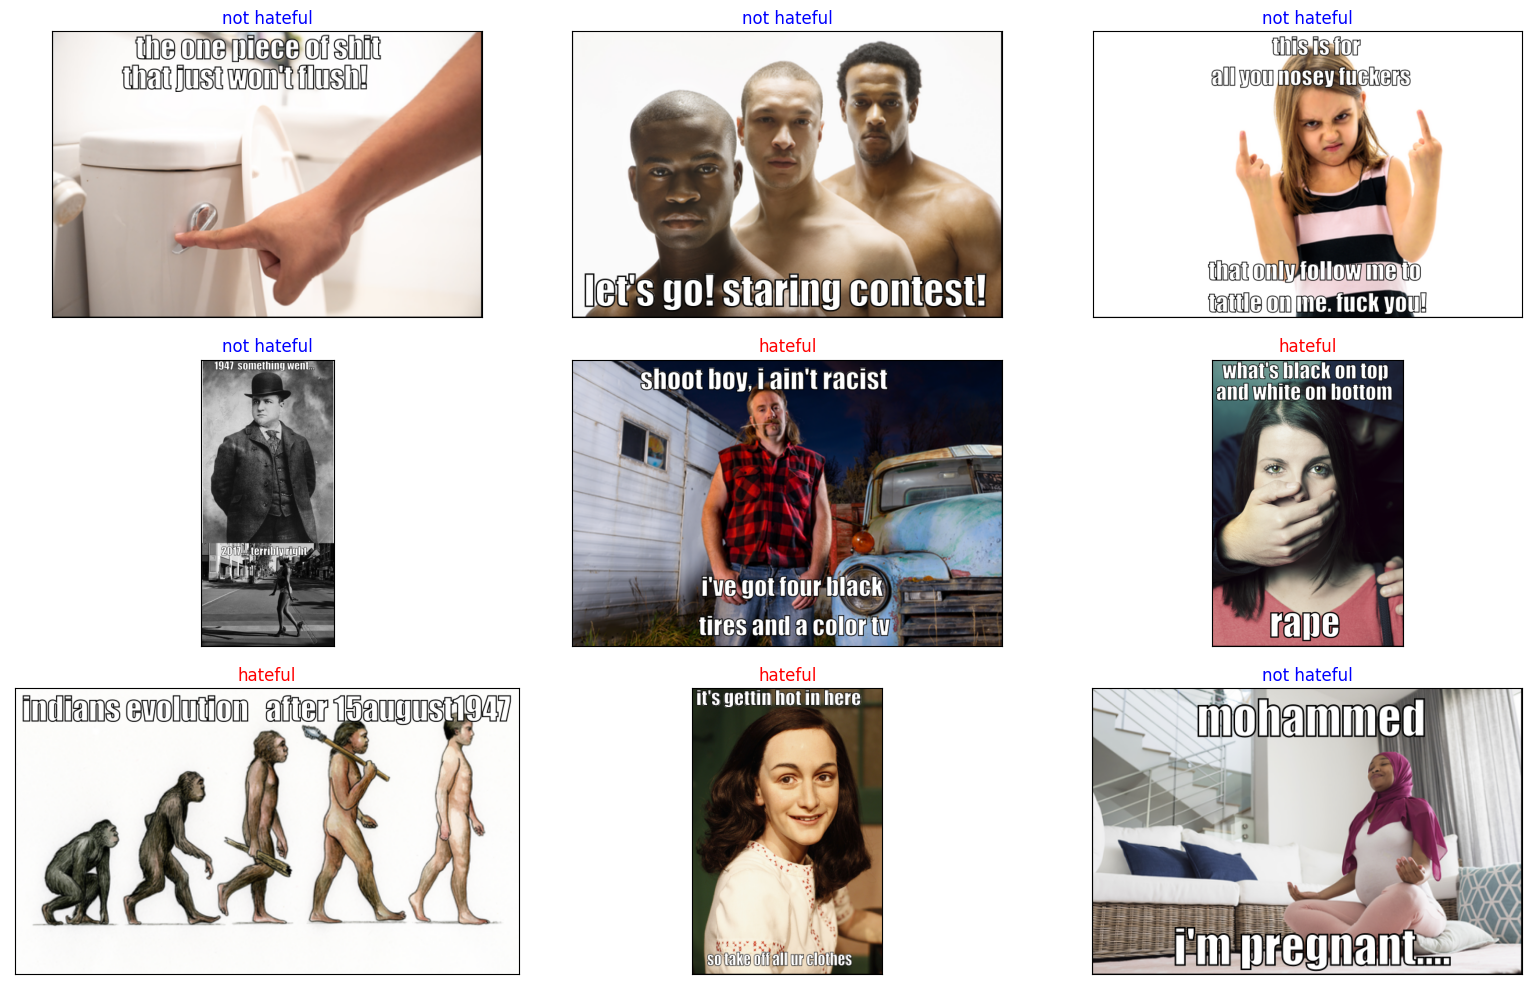

In [21]:
train_dataset = HMDataset(
    images_path, f"{annotations_path}/train_updated.jsonl", image_transform=None
)

plt.figure(figsize=(16, 10))

label_map = {1: "hateful", 0: "not hateful"}

for i, idx in enumerate(np.random.randint(0, len(train_dataset), 9)):
    image, text, label = train_dataset[idx]

    plt.subplot(3, 3, i + 1)
    # C, W, H = image.shape
    # image = image.convert("RGB")
    plt.imshow(image)
    plt.title(label_map[label.item()], color="r" if label else "b")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()


In [24]:
dev_seen.label.value_counts()

0    253
1    247
Name: label, dtype: int64

In [ ]:
from hatememe.dataset import HMDataset

eager_transform = False

train_dataset = HMDataset(
        images_path,
        os.path.join(annotations_path,'train_updated.jsonl'),
        image_transform=preprocess,
        text_transform=text_preprocess,
        eager_transform=eager_transform
    )
    
val_dataset = HMDataset(
        images_path,
        os.path.join(annotations_path,'dev_unseen.jsonl'),
        image_transform=preprocess,
        text_transform=text_preprocess,
        eager_transform=eager_transform
    )
test_dataset = HMDataset(
        images_path,
        os.path.join(annotations_path,'test_unseen.jsonl'),
        image_transform=preprocess,
        text_transform=text_preprocess,
        eager_transform=eager_transform
    )


In [ ]:
import time
CFG.train_image_base_model = CFG.train_text_base_model = False

net = HMMLP(config=CFG())
net = net.to(device)
batch_size = 32
lr = 0.001
if CFG.train_image_base_model:
    lr = 1e-5
    batch_size=8
if eager_transform:
    num_workers=0
else:
    num_workers = 24


criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9,0.98), eps=1e-6, weight_decay=0.5)

epochs = 10
print_every = 200

torch.cuda.empty_cache()
gc.collect()
for epoch in range(epochs):
    # train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    
    running_loss = 0
    for i, data in enumerate(tqdm(train_dataloader), 0):
        images, texts, labels = data
        images = images.to(device)
        texts = texts.to(device)
        labels = labels.squeeze().to(device)

        optimizer.zero_grad()

        # Forward pass on the fused data
        output = net(images, texts)

        loss = criterion(output.squeeze(), labels)

        # Compute gradient
        loss.backward()

        # convert_models_to_fp32(net)
        # Update weight
        optimizer.step()

        running_loss += loss.item()

        if i % print_every == (print_every - 1):
            print(
                f"[Epoch {epoch + 1}, step {i+1:3d}] loss: {running_loss/print_every:.5f}"
            )
            running_loss = 0.0

        torch.cuda.empty_cache()
        gc.collect()

    ## Switch to eval mode
    net.eval()
    running_loss = 0.0
    total_preds = 0
    preds_all_val = torch.tensor([]).cuda()
    labels_all_val = torch.tensor([]).cuda()

    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    for i, data in enumerate(tqdm(val_dataloader), 0):

        images, texts, labels = data
        images = images.to(device)
        texts = texts.to(device)
        labels = labels.squeeze().to(device)

        with torch.no_grad():
            output = net(images, texts)

        loss = criterion(output.squeeze(), labels)

        running_loss += loss.item()

        # Accumulate all predictions and labels
        preds_all_val = torch.cat((preds_all_val, torch.sigmoid(output).squeeze()))
        labels_all_val = torch.cat((labels_all_val, labels))
        
    auroc = BinaryAUROC(pos_label=1)
    auroc_score = auroc(preds_all_val, labels_all_val.int())

    print(
        f"[Epoch {epoch +1}, step {i+1:3d}] val loss: {running_loss/i+1:.5f} accuracy: "
        f"{torch.mean(preds_all_val.int()==labels_all_val, dtype=float)} auroc: {auroc_score}"
    )

    net.train()
    # for child in net.children():
    #     if not child._get_name()=="CLIP":
    #         child.train()


print("Finished Training!")

{'__module__': 'hatememe.config', 'annotations_path': '/home/ridwan.salahuddeen/.cache/torch/mmf/data/datasets/hateful_memes/defaults/annotations/', 'batch_size': 32, 'base_model': 'ViT-B/32', 'device': 'cuda', 'epochs': 10, 'home': '/home/ridwan.salahuddeen', 'images_path': '/home/ridwan.salahuddeen/.cache/torch/mmf/data/datasets/hateful_memes/defaults/images/img/', 'learning_rate': 0.001, 'seed': 42, 'num_linear_layers': 2, 'activation': 'relu', 'fusion_method': 'align', 'train_image_base_model': False, 'train_text_base_model': False, 'image_transform': <property object at 0x7f128b4c2480>, 'text_transform': <property object at 0x7f128b4c24d0>, 'image_feature_extractor': <property object at 0x7f128b4c2520>, 'text_feature_extractor': <property object at 0x7f128b4c2570>, '__dict__': <attribute '__dict__' of 'CFG' objects>, '__weakref__': <attribute '__weakref__' of 'CFG' objects>, '__doc__': None}


 74%|███████▍  | 200/269 [00:50<00:16,  4.26it/s]

[Epoch 1, step 200] loss: 0.68544


100%|██████████| 17/17 [00:03<00:00,  5.09it/s]


[Epoch 1, step  17] val loss: 1.71910 accuracy: 0.6296296296296297 auroc: 0.5


 74%|███████▍  | 200/269 [00:52<00:16,  4.20it/s]

[Epoch 2, step 200] loss: 0.67255


100%|██████████| 17/17 [00:03<00:00,  5.27it/s]


[Epoch 2, step  17] val loss: 1.71509 accuracy: 0.6296296296296297 auroc: 0.5


 74%|███████▍  | 200/269 [00:52<00:18,  3.76it/s]

[Epoch 3, step 200] loss: 0.67091


100%|██████████| 17/17 [00:03<00:00,  5.17it/s]


[Epoch 3, step  17] val loss: 1.71450 accuracy: 0.6296296296296297 auroc: 0.4922058582305908


 18%|█▊        | 48/269 [00:16<01:16,  2.89it/s]


KeyboardInterrupt: 

In [ ]:
# hm_dataset = HMDataset(
#     images_path, f"{annotations_path}/test_unseen.jsonl", image_transform=None
# )

# plt.figure(figsize=(16, 10))

# label_map = {1: "hateful", 0: "not hateful"}

# for i, idx in enumerate(np.random.randint(0, len(hm_dataset), 9)):
#     image, text, label = hm_dataset[idx]

#     ax = plt.subplot(3, 3, i + 1)
#     # C, W, H = image.shape
#     # image = image.convert("RGB")
#     plt.imshow(image)
#     plt.title(label_map[preds_all[idx].item()], color="g" if labels_all[idx]==preds_all[idx] else "r", loc="center")
#     # ax.text(1.2, 1, label_map[preds_all[idx].item()], color="g" if labels_all[idx]==preds_all[idx] else "r", )
#     plt.xticks([])
#     plt.yticks([])

# plt.tight_layout()
